# Coleta de dados com Web Scraping:

In [1]:
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

A primeira coisa é definir de quais cidades queremos extrair informações:

In [2]:
# São Paulo
SP_url = '''https://www.airbnb.com.br/s/Sao-Paulo-~-S%C3%A3o-Paulo--Brazil/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&query=Sao%20Paulo%20-%20S%C3%A3o%20Paulo%2C%20Brazil&place_id=ChIJ0WGkg4FEzpQRrlsz_whLqZs&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click'''

# Rio de Janeiro
RJ_url = '''https://www.airbnb.com.br/s/Rio-de-Janeiro-~-RJ/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&query=Rio%20de%20Janeiro%20-%20RJ&place_id=ChIJW6AIkVXemwARTtIvZ2xC3FA'''

# Belo Horizonte
BH_url = '''https://www.airbnb.com.br/s/Belo-Horizonte-~-MG/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&query=Belo%20Horizonte%20-%20MG&place_id=ChIJMyzPysqQpgARlznSOl55NVs&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click'''

# Manaus
MA_url = '''https://www.airbnb.com.br/s/Manaus-~-AM/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&query=Manaus%20-%20AM&place_id=ChIJt0d2s8gbbJIRzKll959cSCs'''

# Goiânia
GO_url = '''https://www.airbnb.com.br/s/Goi%C3%A2nia-~-GO/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&query=Goi%C3%A2nia%20-%20GO&place_id=ChIJZwjYWL32XpMRjmfSIK0rae8'''

Criamos, então, uma função para gerar listas com cada um dos links das páginas do buscador:

In [3]:
def create_pages(city_url):
    '''
    Esta função retorna uma lista com as urls de cada página de acordo com a cidade em (city_url).
    Input: city_url - String com a url de qualquer cidade definida no buscador do site da Airbnb.
    '''
    # Lista vazia para adicionar cada url de cada página:
    pages = []
    pages.append(city_url)             

    # Loop para adicionar as urls corretamente na lista vazia:
    for i in range(1000):
        soup = BeautifulSoup(requests.get(pages[-1]).content, 'html.parser')
        try:
            url = 'https://www.airbnb.com.br' + soup.find('a', '_1bfat5l').get('href')
        except:
            break
        pages.append(url)
        
    return pages

In [4]:
pages_sp = create_pages(SP_url)
pages_rj = create_pages(RJ_url)
pages_bh = create_pages(BH_url)
pages_ma = create_pages(MA_url)
pages_go = create_pages(GO_url)

Assim, definimos a função para criar os dataframes com os dados de interesse obtidos pela varredura:

In [5]:
# Scraping dos títulos, camas, preços e avaliações de cada uma das acomodações:
def create_df(pages):
    '''
    Esta função retorna um dataframe com todas as informações que extraímos do site da Airbnb.
    Input: pages - Uma lista com as urls de cada página do buscador do site da Airbnb.
    '''
    # Criamos listas vazias para coletar a informação que queremos para criar os datasets:
    titles = []
    links = []
    camas = []
    precos = []
    avaliacoes = []
    
    # Iteração pelo código html de cada página:
    for page in pages:
        soup = BeautifulSoup(requests.get(page).content, 'html.parser')
        
        # Aqui, navegamos pelas tags e classes para coletar a informação desejada:
        for i in range(len(soup.find_all('a', 'ln2bl2p dir dir-ltr'))):
            links.append('https://www.airbnb.com.br' + soup.find_all('a', 'ln2bl2p dir dir-ltr')[i].get('href'))
            titles.append(soup.find_all('div', 't1jojoys dir dir-ltr')[i].get_text())
            camas.append(soup.find_all('div', 'f15liw5s s1cjsi4j dir dir-ltr')[i].get_text())
            precos.append(soup.find_all('div', 'p1v28t5c dir dir-ltr')[i].get_text())
            avaliacoes.append(soup.find_all('span', 'ru0q88m dir dir-ltr')[i].get_text())
    
    # Construção do dataframe com os dados da varredura:
    df = pd.DataFrame({'titles': titles, 'link': links, 'camas': camas, 'precos': precos, 'avaliacoes': avaliacoes})
    
    # Limpeza dos dados dos preços usando regex para extrair apenas valores numéricos:
    df['precos'] = df['precos'].str.extract('(\d+)')
    
    # Transformando dados de preços em valores numéricos:
    df['precos'] = df.precos.astype('float')
    
    return df

Para completar a coleta de dados, construímos o dataframe com as informações de todas as cidades:

In [6]:
df_sp = create_df(pages_sp)
df_rj = create_df(pages_rj)
df_bh = create_df(pages_bh)
df_go = create_df(pages_go)
df_ma = create_df(pages_ma)

In [7]:
df_sp['cidade'] = "São Paulo"
df_rj['cidade'] = "Rio de Janeiro"
df_bh['cidade'] = "Belo Horizonte"
df_go['cidade'] = "Goiania"
df_ma['cidade'] = "Manaus"

# Concatenamos os dataframes de cada cidade num único dataframe (sem repetir os índices):
df = pd.concat([df_sp, df_rj, df_bh, df_go, df_ma], ignore_index=True)

# Limpeza dos dados obtidos com Web Scraping:

Agora que obtivemos os dados do site, e os organizamos em forma de um dataframe, podemos usá-los da forma que desejarmos. Aqui, faremos uma análise simples desses dados, apenas para exemplificar como podemos usar dados obtidos através do método de Web Scraping. Primeiro, vamos verificar algumas informações iniciais:

In [8]:
df.head()

,titles,link,camas,precos,avaliacoes,cidade
0,Apartamento em Pinheiros,https://www.airbnb.com.br/rooms/61877656698582...,1 cama,179.0,"5,0",São Paulo
1,Apartamento em Pinheiros,https://www.airbnb.com.br/rooms/52471075?adult...,11 – 18 de out.,176.0,"5,0",São Paulo
2,Loft em República,https://www.airbnb.com.br/rooms/64913215816992...,1 cama queen,127.0,Novo,São Paulo
3,Apartamento em Bela Vista,https://www.airbnb.com.br/rooms/53956149?adult...,22 – 29 de ago.,163.0,"5,0",São Paulo
4,Apartamento em Jardim Paulista,https://www.airbnb.com.br/rooms/45075705?adult...,1 cama de casal,188.0,"4,75",São Paulo


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   titles      1500 non-null   object 
 1   link        1500 non-null   object 
 2   camas       1500 non-null   object 
 3   precos      1500 non-null   float64
 4   avaliacoes  1500 non-null   object 
 5   cidade      1500 non-null   object 
dtypes: float64(1), object(5)
memory usage: 70.4+ KB


Através de .head(), pudemos ver que adquirimos com sucesso as informações dos títulos, links, cidades, preços e avaliações dos imóveis. Notamos também que a coluna 'camas' veio com algumas informações equivocadas, com algumas instâncias possuindo uma data ao invés da informação sobre as camas. Para resolver esse problema, podemos, por exemplo, remover as instâncias com esses dados equivocados, ou substituí-los, ou mesmo retirar o atributo inteiro, caso a quantidade de camas não seja relevante para a nossa análise.

Também observamos, por .info(), que apenas a coluna de preços está como um dado numérico. Seria interessante que a coluna de avaliações também estivesse em formato numérico, então faremos isso em breve. Antes, porém, vamos verificar se existem itens duplicados, apenas por precaução:

In [10]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados)

Empty DataFrame
Columns: [titles, link, camas, precos, avaliacoes, cidade]
Index: []


Não existem instâncias duplicadas em nosso dataframe. É possível, também, verificar se as colunas possuem algum dado que não é condizente com a coluna. Por exemplo, podemos verificar os tipos de dados de cada categoria presentes na coluna de avaliações:

In [11]:
df['avaliacoes'].value_counts()

5,0     248
Novo    142
4,95     48
4,75     42
4,97     41
       ... 
4,42      1
4,34      1
3,33      1
4,52      1
3,75      1
Name: avaliacoes, Length: 83, dtype: int64

Nesta coluna, esperamos obter apenas os valores das notas de 1 a 5. Entretanto, existem várias instâncias cuja nota está como "Novo". É comum que, para imóveis registrados recentemente no site, a nota seja indicada dessa forma até que hajam avaliações o suficiente para que imóvel possua uma nota que faça sentido. Para simplificar nossas análises, vamos excluir estas instâncias sem avaliação numérica. Iremos também converter as informações dessa coluna em dados numéricos, pois, como visto anteriormente, ela está em forma de 'object', não 'float':

In [12]:
print(df.shape)
df = df.loc[df['avaliacoes'] != 'Novo']
df.shape

(1500, 6)


(1358, 6)

In [13]:
df['avaliacoes'] = df['avaliacoes'].str.replace(",", ".").astype(float)
print(df['avaliacoes'])

0       5.00
1       5.00
3       5.00
4       4.75
5       4.60
        ... 
1495    5.00
1496    4.50
1497    5.00
1498    4.67
1499    5.00
Name: avaliacoes, Length: 1358, dtype: float64


Nosso objetivo é fazer uma comparação simplificada entre os preços e avaliações dos apartamentos em algumas capitais brasileiras. Dessa forma, vamos focar apenas nos atributos de preços, avaliações e cidades, e remover as outras colunas do dataframe (inclusive a coluna 'camas', que veio com informações não desejadas):

In [14]:
df = df.drop('camas', axis=1)
df = df.drop('link', axis=1)
df = df.drop('titles', axis=1)
df.head()

,precos,avaliacoes,cidade
0,179.0,5.00,São Paulo
1,176.0,5.00,São Paulo
3,163.0,5.00,São Paulo
4,188.0,4.75,São Paulo
5,81.0,4.60,São Paulo


# Visualização dos dados obtidos com Web Scraping:

Agora sim, depois desta breve limpeza dos dados, podemos começar a comparar as cidades de forma mais clara. Vamos, dessa forma, ver a comparação de preços entre as cinco cidades:

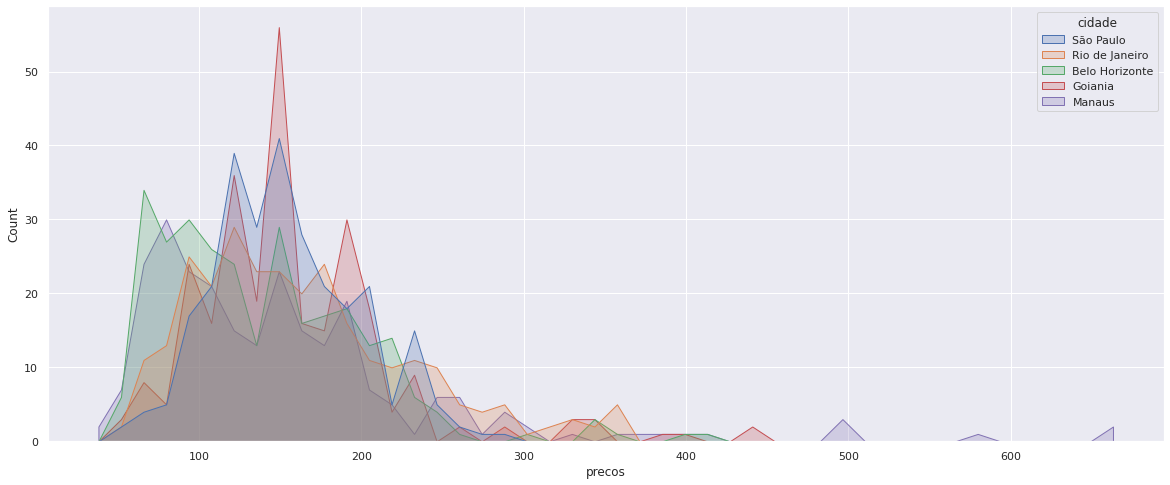

In [15]:
df.reset_index(drop=True)
sns.set(rc={'figure.figsize':(20, 8)})
ax = sns.histplot(data=df, x="precos", hue="cidade", element="poly", discrete=False);
plt.show()

Mas assim está difícil entender com clareza as diferenças de preços. Podemos tentar visualizar melhor separando os histogramas de cada cidade em um 'ridge plot':

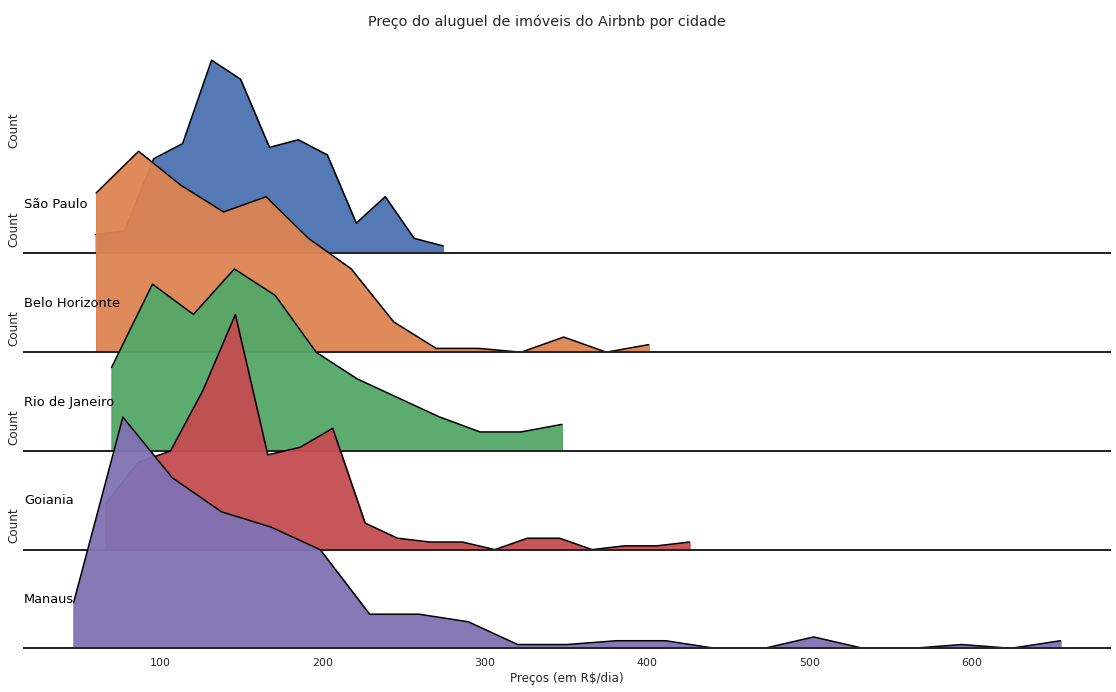

In [26]:
g = sns.FacetGrid(df, row="cidade", hue="cidade", aspect=8, height=2)

palette = sns.color_palette("Set2", 12)
g.map_dataframe(sns.histplot, element="poly", discrete=False, x="precos", palette=palette)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
g.map_dataframe(sns.histplot, element="poly", discrete=False, x="precos", fill=True, alpha=0.8)
g.map_dataframe(sns.histplot, element="poly", discrete=False, x="precos", fill=False, color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "cidade")
plt.suptitle('Preço do aluguel de imóveis do Airbnb por cidade', y=0.95)
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")

g.set_titles("")
g.set(yticks=[], xlabel="Preços (em R$/dia)")
g.despine(left=True)

Agora sim, ficou mais clara a diferença entre as cidades. Podemos observar, por exemplo, que Belo Horizonte e Manaus possuem mais imóveis com preços mais baixos do que São Paulo e Goiânia, e que Manaus é também quem mais possui imóveis com um valor em torno de 500 reais a diária. Mas é importante notar que esta comparação somente é válida porque os eixos verticais de cada histograma estão na mesma escala.

Podemos empregar a mesma visualização nas avaliações dos imóveis:

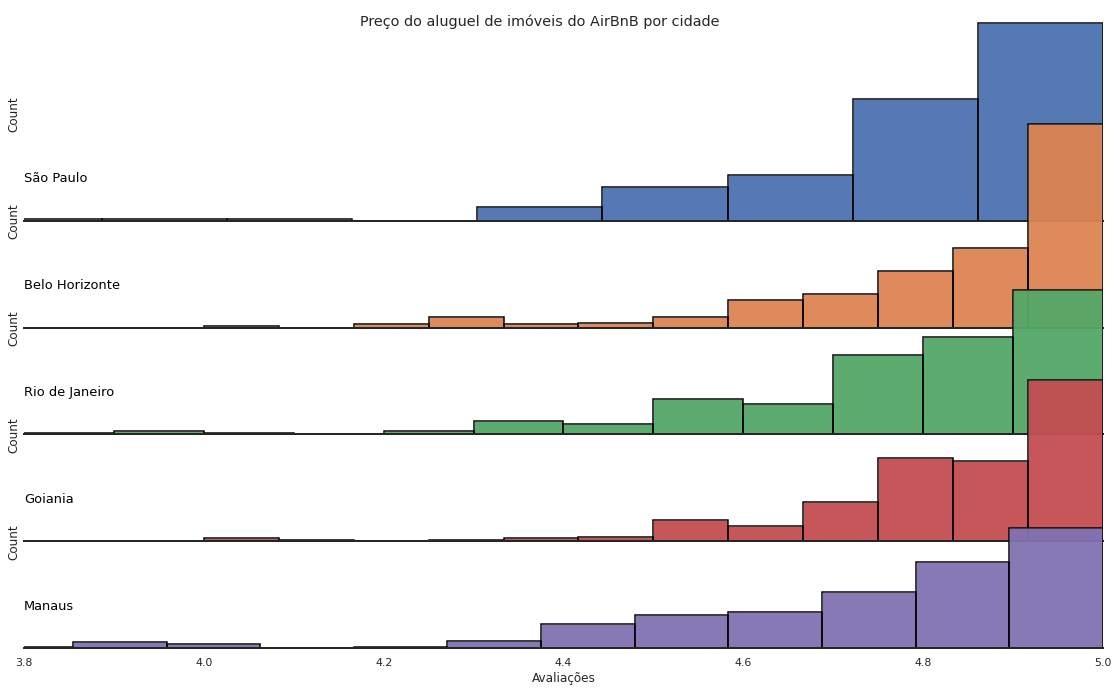

In [17]:
df = df.sort_values(by=['avaliacoes'], ascending=False)

g = sns.FacetGrid(df, row="cidade", hue="cidade", aspect=8, height=2)

palette = sns.color_palette("Set2", 12)
g.map_dataframe(sns.histplot, bins=12, element="bars", discrete=False, x="avaliacoes", palette=palette)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
g.map_dataframe(sns.histplot, bins=12, element="bars", discrete=False, x="avaliacoes", fill=True, alpha=0.8)
g.map_dataframe(sns.histplot, bins=12, element="bars", discrete=False, x="avaliacoes", fill=False, color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "cidade")
plt.suptitle('Preço do aluguel de imóveis do AirBnB por cidade', y=0.95)
plt.xlim(3.8, 5.0)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")

g.set_titles("")
g.set(yticks=[], xlabel="Avaliações")
g.despine(left=True)

Mas desta vez a comparação visual é mais difícil. Talvez se usarmos um 'violin plot', as diferenças entre as avaliações fique mais evidente:

(3.6, 5.0)

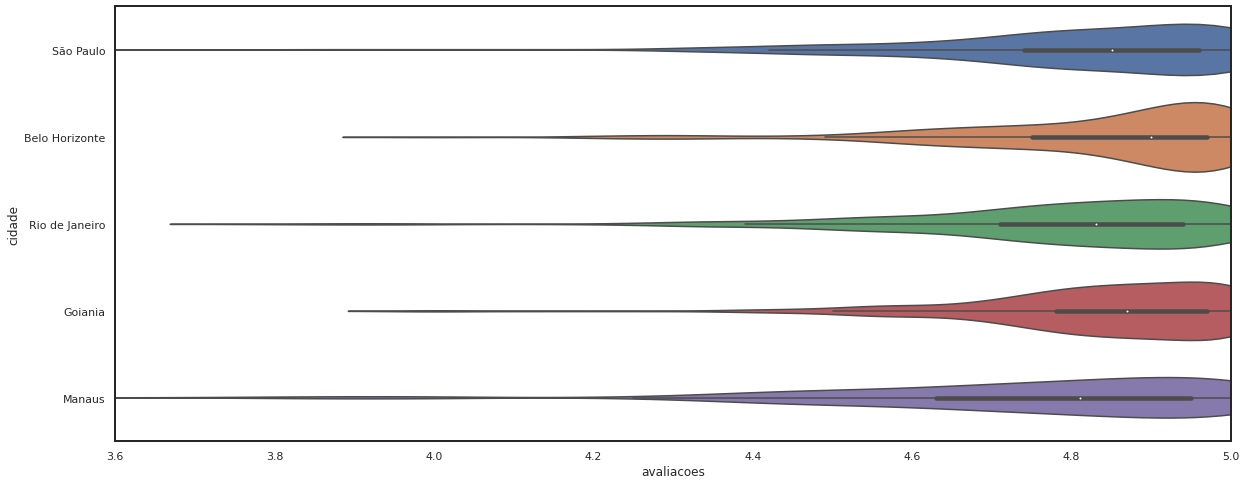

In [18]:
sns.violinplot(x='avaliacoes', y='cidade', data=df)
plt.xlim(3.6, 5.0)

Observamos que, com relação as avaliações, Belo Horizonte possui uma concentração maior de avaliações próximas de 5.0, e as avaliações de Manaus estão mais diluídas, havendo uma grande quantidade de avaliações desde o 4.5 até o 4.9.

É possível, ainda, comparar estes valores das avaliações com o uso de um 'box plot':

(3.8, 5.0)

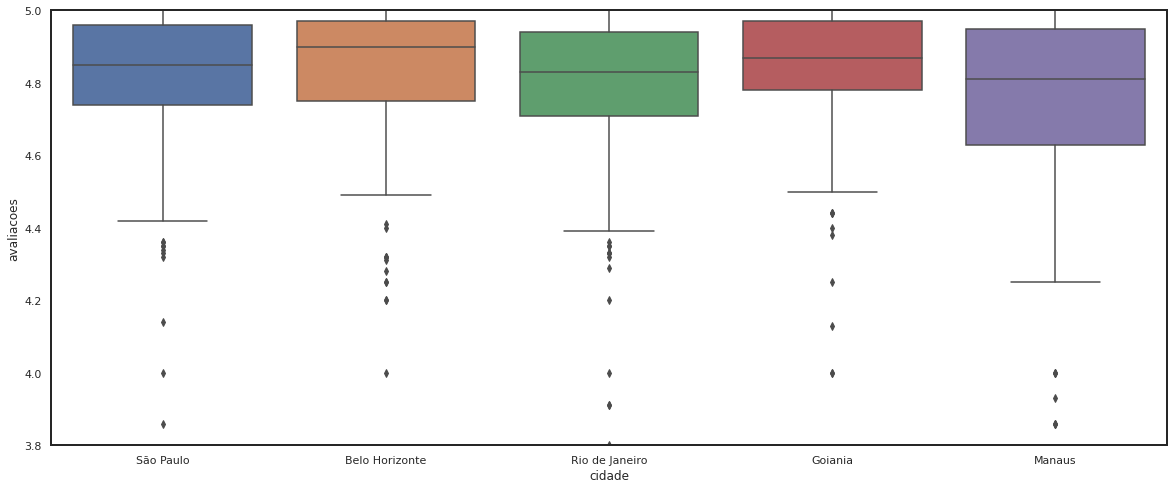

In [28]:
ax = sns.boxplot(x="cidade", y="avaliacoes", data=df)
plt.ylim(3.8, 5.0)

Desse modo, confirmamos que os valores médios de Belo Horizonte e de Goiânia estão concentrados mais próximos do 4.9 ou 5.0 do que as avaliações de Manaus e do Rio de Janeiro.

Podemos, é claro, analisar esses valores de forma mais objetiva calculando a média de cada cidade, tanto das avaliações quanto dos preços das diárias:

In [20]:
import statistics

df_sp = df.loc[df['cidade'] == 'São Paulo']
df_rj = df.loc[df['cidade'] == 'Rio de Janeiro']
df_bh = df.loc[df['cidade'] == 'Belo Horizonte']
df_ma = df.loc[df['cidade'] == 'Manaus']
df_go = df.loc[df['cidade'] == 'Goiania']

print('Preço médio de São Paulo: ', statistics.mean(df_sp['precos']))
print('Preço médio do Rio de Janeiro: ', statistics.mean(df_rj['precos']))
print('Preço médio de Belo Horizonte: ', statistics.mean(df_bh['precos']))
print('Preço médio de Manaus: ', statistics.mean(df_ma['precos']))
print('Preço médio de Goiania: ', statistics.mean(df_go['precos']))

Preço médio de São Paulo:  153.63272727272727
Preço médio do Rio de Janeiro:  162.1485507246377
Preço médio de Belo Horizonte:  137.4280701754386
Preço médio de Manaus:  151.62248995983936
Preço médio de Goiania:  156.4981684981685


Fica claro, desse modo, que o Rio é a cidade com o preço médio mais alto, seguida por Goiânia, e que as cidades mais baratas são Belo Horizonte, e em seguida Manaus e São Paulo. Agora, com relação as avaliações:

In [21]:
print('Avaliação média de São Paulo: ', statistics.mean(df_sp['avaliacoes']))
print('Avaliação média do Rio de Janeiro: ', statistics.mean(df_rj['avaliacoes']))
print('Avaliação média de Belo Horizonte: ', statistics.mean(df_bh['avaliacoes']))
print('Avaliação média de Manaus: ', statistics.mean(df_ma['avaliacoes']))
print('Avaliação média de Goiania: ', statistics.mean(df_go['avaliacoes']))

Avaliação média de São Paulo:  4.805490909090909
Avaliação média do Rio de Janeiro:  4.7843478260869565
Avaliação média de Belo Horizonte:  4.842842105263158
Avaliação média de Manaus:  4.753935742971888
Avaliação média de Goiania:  4.837069597069597


Notamos que as avaliações médias de Belo Horizonte, Goiânia e São Paulo são as mais altas, e que as notas do Rio e de Manaus estão um pouco abaixo (como vimos anteriormente, através do 'violin plot' e do 'box plot').

Outra informação interessante é saber como os dados se correlacionam entre sí. Se, por exemplo, as instâncias com avaliações maiores tendem a ter preços maiores ou se o número de quartos influencia na avaliação ou no preço das acomodações. Pelo fato de termos focado nas avaliações e preços, vamos observar a relação entre ambos pela 'matriz de correlação':

<AxesSubplot:>

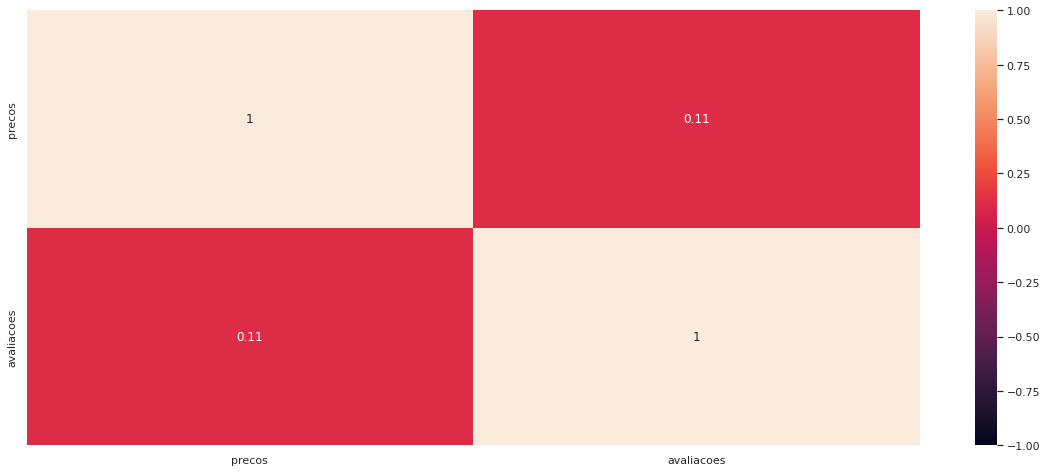

In [22]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

Quando o valor é próximo de 1, significa que os atributos estão fortemente correlacionados (caso um valor seja maior, o outro será maior igualmente, e caso seja menor, o outro será menor também). Se o valor seja mais perto de -1, a correlação entre ambos também é forte, mas no sentido oposto (caso um atributo varie em um sentido, o outro irá variar no sentido oposto). Mas a correlação entre preços e avaliações é próxima de zero, o que nos diz que eles estão fracamente correlacionados, ou seja, acomodações com preços altos ou baixos podem ter tanto avaliações boas quanto avaliações ruins.

A motivação desta visualização dos dados obtidos com Web Scraping era apenas ilustrativa. Para uma quantidade grande de dados poderíamos, por exemplo, remover os dados 'outliers' (os 'pontos fora da curva', que não representam a tendência geral da maioria dos dados), ou pensar em correlacionar a quantidade de quartos ou camas com o preço ou as avaliações. Poderíamos também estudar as proximidades de cada imóvel, ou a localização relativa dentro de uma mesma cidade, para avaliar se um imóvel bem localizado é mais procurado ou mais custoso.

É possível, ainda, usar algoritmos de machine learning, como as random forests ou regressão linear, para tentar criar um modelo que prevê a avaliação de uma acomodação com base no número de cômodos, na localização, na área em m², ou outras informações que possam ser relevantes para esse dado.

São inúmeras as possibilidades de usos para dados obtidos da internet, desde a análise de preços de produtos online até estudos científicos robustos, e isso torna o Web Scraping uma ferramenta muito útil e muito poderosa, especialmente para os cientistas de dados. Para saber mais sobre limpeza de dados ou sobre visualização de dados, ou até mesmo sobre machine learning, recomendamos os Turing Talks que falam especificamente sobre esses temas:

Limpeza de Dados - https://medium.com/turing-talks/como-fazer-uma-limpeza-de-dados-completa-em-python-7abc9dfc19b8

Visualização de Dados - https://medium.com/turing-talks/turing-talks-9-visualiza%C3%A7%C3%A3o-de-dados-93df670d479

Machine Learning - https://medium.com/turing-talks/turing-talks-2-o-que-%C3%A9-machine-learning-b7e7654a86f2